<h1 style="font-size:40px;"><center>Exercise I:<br> Multi-layer perceptrons
for classification and regression problems.
</center></h1>


# Introduction

Welcome to the second lab in the Deep learning course! In this lab we will continue to take a look at the following;
* train MLPs and for both classification and regression problems
* overfit models and see how overfitting changes validation performance
* avoid overfitting using regularization
* do model selection

The lab include different datasets, binary and multiple classification problems and function approximation problems. A report will be written at the end of the notebook. 

Three different synthetic classification problems will be used. They are all 2D binary classification problems which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. They are called *syn1, syn2* and *syn3*. Each of these datasets are generated "on the fly" each time. They come from various normal distributions. Since they are generated using random numbers it means that each time you generate the data it will be slightly different from next time. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot these datasets.

Have fun!

---

The following code allows us to edit imported files without restarting the kernel for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Hacky solution to access the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

from config import flying_objects_config
from dataset import MLPData

In [51]:
from DL_labs.utils import (
    plot
    trainer, 
    metrics,
    progressbar
) 

cfg = flying_objects_config()

# Defining the MLP model

This cell defines the MLP model. There are a number of parameters that is needed to 
define a model. Here is a list of them: **Note:** They can all be specified when you call
this function in later cells. The ones specified in this cell are the default values.


In [5]:
class MLP(torch.nn.Module):
        def __init__(self, 
                    inp_dim=None,         
                    hidden_nodes=1,                      # number of nodes in hidden layer
                    num_out=None,
                    **kwargs
                ):
            super(MLP, self).__init__()
            self.fc1 = torch.nn.Linear(inp_dim, hidden_nodes)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(hidden_nodes, num_out)
            
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            return torch.sigmoid(output)

## Plotting the data
This cell defines the three different synthetic data sets and the Spiral dataset.

Here we just generate 100 cases for syn1-syn3 and the spiral dataset and plot them. Run the cell by entering into the cell and press "CTRL Enter". 

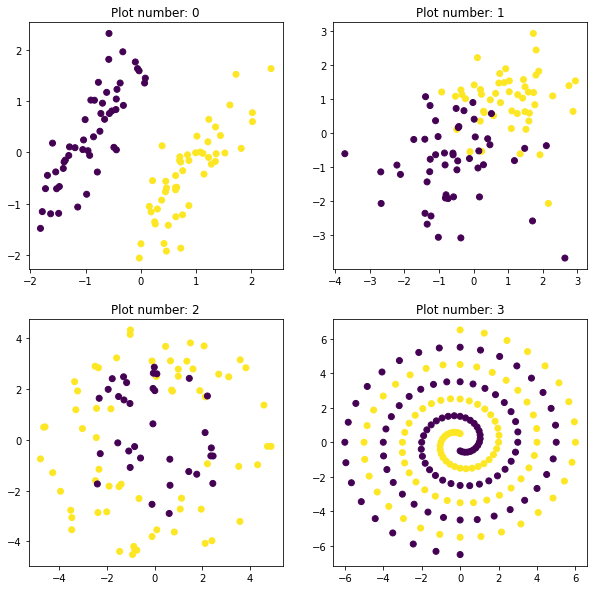

In [55]:
plot.data_distribution([
    MLPData.syn1(100),
    MLPData.syn2(100),
    MLPData.syn3(100),
    MLPData.spiral(cfg.spiral_path)
])

## Define a function that allow us to convert numpy to pytorch DataLoader

In [53]:
def numpy2Dataloader(x,y, batch_size=25, num_workers=10,**kwargs):
    return DataLoader(
        TensorDataset(
            torch.from_numpy(x).float(), 
            torch.from_numpy(y).unsqueeze(1).float()
        ),
        batch_size=batch_size,
        num_workers=num_workers,
        **kwargs
    )

# Excercise 1
The cell below should be used for question 1. Looking at the code will help you understand how the network is created, trained and evaluated. It will be useful for the other questions.

**TODO:** Use syn1 with 100 data points and train a linear MLP to separate the two classes, i.e. use a single hidden node. What happened? Can the problem be solved with a single hidden node?

## Code

In [10]:
from DL_labs.utils.trainer import Agent
from torch.utils.data import TensorDataset, DataLoader

First we convert our dataset into a pytorch Dataset. Thereafter we load it into our DataLoader. Note that we here define the batch_size and the number of workers that should be used. 

In [56]:
x,y = MLPData.syn1(10000)
train_loader = numpy2Dataloader(x,y)

Setup our local config that should be used for the trainer.

In [12]:
config = {
    'model_params':{
        'inp_dim':x.shape[1],         
        'hidden_nodes':1,   # activation functions for the hidden layer
        'num_out':1 # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes
    },
    'optimizer':'Adam',               # minimization method
    'criterion':'BCELoss', # error function
    'max_epochs':4,
}

Lastly, put everything together and call on the trainers fit method. 

In [13]:
model = Agent(MLP,**config)
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=cfg.GPU,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
trainer.fit(
    model, 
    train_dataloader=train_loader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/stud/f/fremar16/miniconda3/envs/DL-Labs/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3: 100%|██████████| 400/400 [00:03<00:00, 126.13it/s, loss=0.134, v_num=0.1]


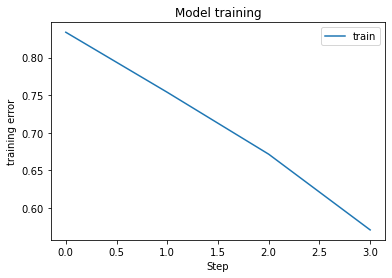

/home/stud1/f/fremar16/DL_labs/utils/plot.py:39: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, cmap=plt.cm.Paired)


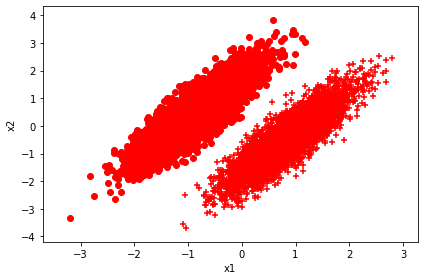

In [14]:
# Some plotting
plt.plot(trainer.logger.data['loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('Step')
plt.legend(['train'], loc=0)
plt.show()

plot.decision_bondary(trainer.get_model(), x,y) # To be fixed!

In [15]:
#metrics.stats_class()
metrics.stats_class(x, y, 'Training', trainer.get_model())


 ########## STATISTICS for Training Data ########## 

Accuracy   0.5
Sensitivity   0.0
Specificity   1.0
Loss   Not implemented

 ##################################################
